In [41]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [42]:
# Model

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1),
        )
    def forward(self, x): return self.net(x)

def make_model():
    torch.manual_seed(42)   # to ensure identical init per optimizer
    return MLP()


## Gradient Descent (GD)

**Update rule**

$$
\theta_{t+1} = \theta_t - \eta \, g_t
$$

where
$$
g_t = \nabla_\theta L(\theta_t)
$$

- **Key idea**: Same learning rate (η) for every parameter.  
- **Pros**: Simple, intuitive.  
- **Cons**: One-size-fits-all step → unstable if gradient magnitudes differ.

---

In [43]:

class GradientDescent:

    def __init__(self, params, lr=1e-2, weight_decay=0.0):

        if lr <= 0:
            raise ValueError("lr must be positive")
        self.params = list(params)
        self.lr = lr
        self.weight_decay = weight_decay

    @torch.no_grad()

    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            g = p.grad
            if self.weight_decay != 0.0:
                g = g.add(self.weight_decay * p)
            p.add_(g, alpha=-self.lr)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


## SGD with Momentum

**Equations**

$$
v_t = \beta v_{t-1} + g_t
$$

$$
\theta_{t+1} = \theta_t - \eta v_t
$$

- **Key idea**: Adds a “velocity” term that accumulates gradient history.  
- **Effect**:  
  - Speeds up when gradients align (accelerator).  
  - Smooths out oscillations.  
- **Variant**: *Nesterov momentum* (lookahead step).

---

In [44]:

class SGDMomentum:
    """
    SGD with Momentum (optionally Nesterov), PyTorch-style API.
    θ <- θ - lr * v,    v <- β v + g     (Nesterov: use βv + g as lookahead)
    """
    def __init__(self, params, lr=1e-2, momentum=0.9, weight_decay=0.0, nesterov=False):
        if lr <= 0: raise ValueError("lr must be positive")
        if momentum < 0: raise ValueError("momentum must be >= 0")
        self.params = list(params)
        self.lr = lr
        self.beta = momentum
        self.weight_decay = weight_decay
        self.nesterov = nesterov
        self._vel = {}  # per-param velocity buffers

    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            g = p.grad
            if self.weight_decay != 0.0:
                g = g.add(self.weight_decay * p)   # L2 regularization: g += λθ

            # get / init velocity
            v = self._vel.get(p)
            if v is None:
                v = torch.zeros_like(p)
                self._vel[p] = v

            # v <- β v + g
            v.mul_(self.beta).add_(g)

            # Nesterov uses lookahead gradient: update = g + β v
            update = (g.add(self.beta * v)) if self.nesterov else v

            # θ <- θ - lr * update
            p.add_(update, alpha=-self.lr)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


## RMSprop

**Equations**

$$
s_t = \alpha s_{t-1} + (1-\alpha) g_t^2
$$

$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{s_t}+\epsilon}\,g_t
$$

- **Key idea**: Per-parameter *adaptive learning rate*.  
- **Effect**:  
  - Parameters with consistently **large gradients** → step shrinks.  
  - Parameters with **small gradients** → step grows.  
- **Analogy**: cautious steps on steep slopes, long strides on flat ones.  
- **History**: Proposed by Hinton (2012); used in DeepMind’s Atari DQN.

---

In [45]:
import torch

class RMSprop:
    """
    RMSprop optimizer (PyTorch-style API).
    Update (vanilla):
        s_t = alpha * s_{t-1} + (1 - alpha) * g_t^2
        theta <- theta - lr * g_t / (sqrt(s_t) + eps)

    With momentum:
        m_t = beta * m_{t-1} + g_t / (sqrt(s_t) + eps)
        theta <- theta - lr * m_t

    Centered (like PyTorch's centered=True):
        g_avg_t = alpha * g_avg_{t-1} + (1 - alpha) * g_t
        denom = sqrt(s_t - g_avg_t^2 + eps)

    Args:
        params: iterable of tensors with requires_grad=True
        lr: learning rate
        alpha: EMA decay for squared grads
        eps: numerical stability
        weight_decay: L2 regularization (adds λ * θ to gradient)
        momentum: 0.0 disables momentum; >0 enables velocity on normalized grad
        centered: if True, normalize by variance estimate (s - g_avg^2)
    """
    def __init__(self, params, lr=1e-3, alpha=0.99, eps=1e-8,
                 weight_decay=0.0, momentum=0.0, centered=False):
        if lr <= 0: raise ValueError("lr must be positive")
        if not (0 < alpha < 1): raise ValueError("alpha must be in (0,1)")
        if momentum < 0: raise ValueError("momentum must be >= 0")

        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.centered = centered

        # per-parameter state
        self._sq_avg = {}   # E[g^2]
        self._grad_avg = {} # E[g] (only if centered)
        self._mom = {}      # momentum buffer (only if momentum>0)

    @torch.no_grad()
    def step(self):
        a = self.alpha

        for p in self.params:
            if p.grad is None:
                continue
            g = p.grad

            # L2 regularization as gradient add-on: g += λ * θ
            if self.weight_decay != 0.0:
                g = g.add(self.weight_decay * p)

            # init buffers
            sq = self._sq_avg.get(p)
            if sq is None:
                sq = torch.zeros_like(p)
                self._sq_avg[p] = sq

            # s_t = a*s_{t-1} + (1-a)*g^2
            sq.mul_(a).addcmul_(g, g, value=1 - a)

            if self.centered:
                ga = self._grad_avg.get(p)
                if ga is None:
                    ga = torch.zeros_like(p)
                    self._grad_avg[p] = ga
                # g_avg_t = a*g_avg_{t-1} + (1-a)*g
                ga.mul_(a).add_(g, alpha=1 - a)
                # denom = sqrt(E[g^2] - (E[g])^2 + eps)
                denom = (sq - ga.pow(2)).clamp_min(0).sqrt().add_(self.eps)
            else:
                denom = sq.sqrt().add_(self.eps)

            # normalized gradient
            upd = g / denom

            if self.momentum > 0.0:
                m = self._mom.get(p)

                if m is None:
                    m = torch.zeros_like(p)
                    self._mom[p] = m

                # m_t = beta*m_{t-1} + upd
                m.mul_(self.momentum).add_(upd)
                p.add_(m, alpha=-self.lr)
            else:
                p.add_(upd, alpha=-self.lr)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


## Adam

**Equations**

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2
$$

**Bias correction**

$$
\hat{m}_t = \frac{m_t}{1-\beta_1^t}, \qquad
\hat{v}_t = \frac{v_t}{1-\beta_2^t}
$$

**Update**

$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t}+\epsilon}\,\hat{m}_t
$$

- **Key idea**: Combines **momentum (accelerator)** + **RMSprop (brake)** + **bias correction**.  
- PROs- Default choice in many deep learning tasks.  
- CONS- Sometimes overfits or generalizes worse than SGD.

---

In [46]:
import torch

class Adam:
    """
    Adam optimizer (PyTorch-style API), with bias correction.
    m_t = β1 m_{t-1} + (1-β1) g_t
    v_t = β2 v_{t-1} + (1-β2) g_t^2
    m̂_t = m_t / (1-β1^t),  v̂_t = v_t / (1-β2^t)
    θ ← θ - lr * m̂_t / (sqrt(v̂_t) + eps)

    Args:
        params: iterable of tensors
        lr: learning rate
        betas: (β1, β2)
        eps: numerical stability
        weight_decay: L2 (adds λ * θ to grad)
        amsgrad: if True, use v̂max for denominator (improves worst-case convergence)
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0.0, amsgrad=False):
        if lr <= 0: raise ValueError("lr must be positive")
        b1, b2 = betas
        if not (0 < b1 < 1 and 0 < b2 < 1): raise ValueError("betas must be in (0,1)")
        self.params = list(params)
        self.lr = lr
        self.b1, self.b2 = b1, b2
        self.eps = eps
        self.weight_decay = weight_decay
        self.amsgrad = amsgrad

        self._m = {}       # first moment
        self._v = {}       # second moment
        self._vmax = {}    # for AMSGrad
        self._step = 0     # global step for bias correction

    @torch.no_grad()
    def step(self):
        self._step += 1
        b1t = 1 - self.b1 ** self._step
        b2t = 1 - self.b2 ** self._step

        for p in self.params:
            if p.grad is None:
                continue
            g = p.grad

            if self.weight_decay != 0.0:
                g = g.add(self.weight_decay * p)

            m = self._m.get(p)
            if m is None:
                m = torch.zeros_like(p)
                self._m[p] = m
            v = self._v.get(p)
            if v is None:
                v = torch.zeros_like(p)
                self._v[p] = v

            # moments
            m.mul_(self.b1).add_(g, alpha=1 - self.b1)
            v.mul_(self.b2).addcmul_(g, g, value=1 - self.b2)

            if self.amsgrad:
                vmax = self._vmax.get(p)
                if vmax is None:
                    vmax = torch.zeros_like(p)
                    self._vmax[p] = vmax
                torch.maximum(vmax, v, out=vmax)
                denom = vmax.sqrt().add_(self.eps)
            else:
                denom = v.sqrt().add_(self.eps)

            # bias correction
            mhat = m / b1t
            vhat = denom if self.amsgrad else (v / b2t).sqrt().add_(self.eps)

            # update
            p.addcdiv_(mhat, vhat, value=-self.lr)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [47]:
# wrapper that trains the same model with a given optimizer and collects the loss curve,
# so you can compare optimizers fairly (same data, same model, same number of epochs).

def train_with_optimizer(OptimizerClass, opt_kwargs, epochs=200):
    model = make_model()
    loss_fn = nn.MSELoss()
    opt = OptimizerClass(model.parameters(), **opt_kwargs)
    losses = []
    for _ in range(epochs):
        epoch_loss = 0.0; n_batches = 0
        for Xb, yb in loader:
            y_pred = model(Xb)
            loss = loss_fn(yb, y_pred)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item(); n_batches += 1
        losses.append(epoch_loss / n_batches)
    return losses

In [48]:
# Toy dataset

torch.manual_seed(42); np.random.seed(42)
N = 512
X = torch.linspace(-2, 2, N).unsqueeze(1)
y = 2*X**3 - 1.0*X**2 + 0.5*X + 0.2*torch.randn_like(X)
loader = DataLoader(TensorDataset(X, y), batch_size=32, shuffle=True)


In [49]:
epochs = 200

cfgs = {
    "GD(lr=1e-2)":             (GradientDescent, dict(lr=1e-3)),
    "Momentum(lr=1e-2,β=0.9)": (SGDMomentum,    dict(lr=1e-3, momentum=0.9)),
    "RMSprop(lr=1e-3)":        (RMSprop,        dict(lr=1e-3, alpha=0.99)),
    "Adam(lr=1e-3)":           (Adam,           dict(lr=1e-3)),
}

all_losses = {}

for name, (Opt, kw) in cfgs.items():
    all_losses[name] = train_with_optimizer(Opt, kw, epochs=epochs)

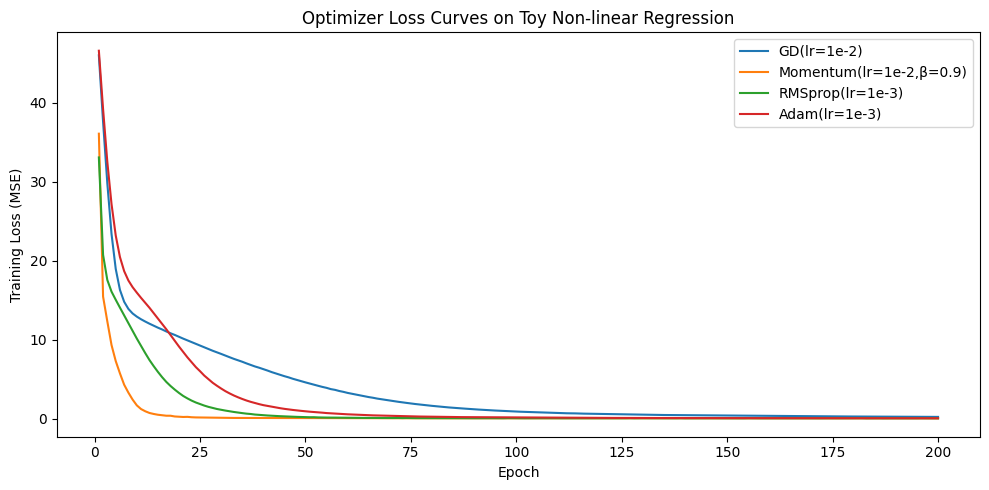

In [50]:
plt.figure(figsize=(10,5))

for name, losses in all_losses.items():
    plt.plot(range(1, epochs+1), losses, label=name)

plt.xlabel("Epoch"); plt.ylabel("Training Loss (MSE)")
plt.title("Optimizer Loss Curves on Toy Non-linear Regression")
plt.legend(); plt.tight_layout()
plt.show()

---

## Comparison

| Optimizer | Core Idea | Analogy | Pros | Cons |
|-----------|-----------|---------|------|------|
| **GD** | Constant step size for all params | Same stride everywhere | Simple | Unstable with varying slopes |
| **Momentum** | Accumulate past gradients | Push a cart downhill | Faster convergence, smooth | May overshoot |
| **RMSprop** | Scale step by avg. squared grad | Short steps on steep slopes | Adaptive per-param | Ignores direction history |
| **Adam** | Momentum + RMSprop + bias correction | Accelerator + brakes | Stable, fast, widely used | Can overfit, needs tuning |

---